# Train and test DNN models for parking space prediction

In [205]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
target_time_period= 'july'
#target_time_period= 'sept_oct'

In [207]:
#To do: 
#0. training_rate =.7 DONE!!!
#1.probar weather + flow
#2. concatenar julio + sept-oct

## General functions

In [208]:
def read_clean_subflows_fn(critera, time_period):
    subflows= {}
    for c in critera:
        df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean_{}.csv'.format(c, time_period)),
                       parse_dates=[0], index_col=0)
        subflows[c] = df
    return subflows

## Read zones 1 parking data (target variable)

In [209]:
zone1_df = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')

In [210]:
zone1_df.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


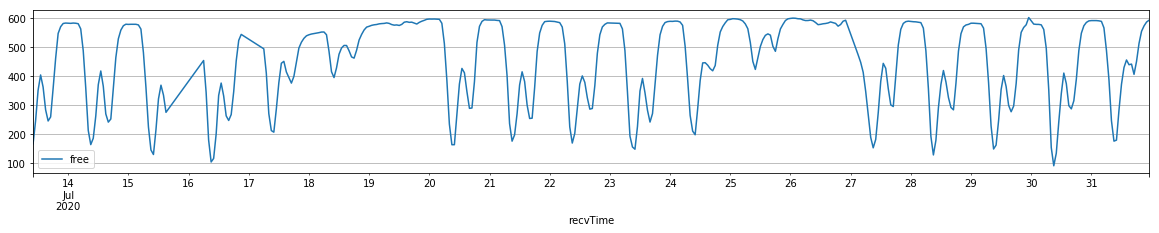

In [211]:
zone1_df.plot(figsize=(20,3),grid=True);

In [212]:
target_days = zone1_df.index

## Read subflows

In [213]:
target_criteria = range(6,11)

In [214]:
mob_flows = read_clean_subflows_fn(target_criteria, 'july')

## Read meteorological data

In [215]:
target_days

DatetimeIndex(['2020-07-13 10:00:00', '2020-07-13 11:00:00',
               '2020-07-13 12:00:00', '2020-07-13 13:00:00',
               '2020-07-13 14:00:00', '2020-07-13 15:00:00',
               '2020-07-13 16:00:00', '2020-07-13 17:00:00',
               '2020-07-13 18:00:00', '2020-07-13 19:00:00',
               ...
               '2020-07-31 14:00:00', '2020-07-31 15:00:00',
               '2020-07-31 16:00:00', '2020-07-31 17:00:00',
               '2020-07-31 18:00:00', '2020-07-31 19:00:00',
               '2020-07-31 20:00:00', '2020-07-31 21:00:00',
               '2020-07-31 22:00:00', '2020-07-31 23:00:00'],
              dtype='datetime64[ns]', name='recvTime', length=446, freq=None)

In [216]:
meteor = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'meteor.txt'), sep=';', parse_dates={'date': ['fecha', 'hora']}, index_col='date')

meteor= meteor.loc[meteor.index.intersection(target_days)]


In [217]:
meteor = meteor.iloc[:,[0,6,8,11]]
meteor.head()

,tmed,radmed,vvmed,prec
2020-07-13 10:00:00,31.6,887.5,1.4,0.0
2020-07-13 11:00:00,33.0,954.2,1.7,0.0
2020-07-13 12:00:00,33.4,965.5,1.9,0.0
2020-07-13 13:00:00,33.9,923.3,2.1,0.0
2020-07-13 14:00:00,33.1,824.0,2.4,0.0


In [218]:
meteor.shape

(446, 4)

In [219]:
zone1_df.shape

(446, 1)

tmed vs free parking

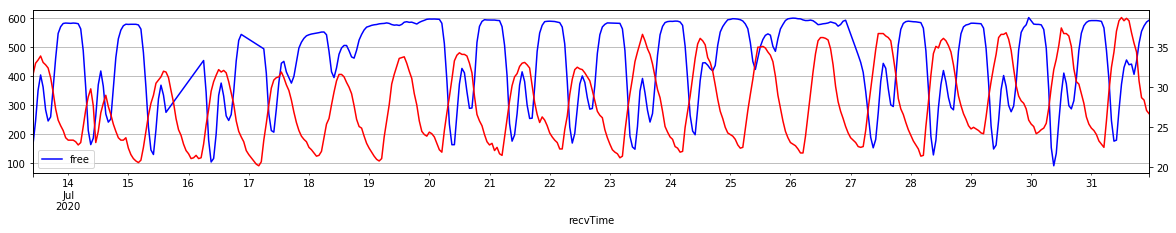

In [220]:
ax= zone1_df.plot(figsize=(20,3),grid=True, color='blue');
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
meteor['tmed'].plot(ax=ax2, color='red');

In [221]:
r, p = pearsonr(zone1_df['free'], meteor['tmed'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.5538527681021218 and p-value: 3.2328634278388953e-37


radmed vs free parking

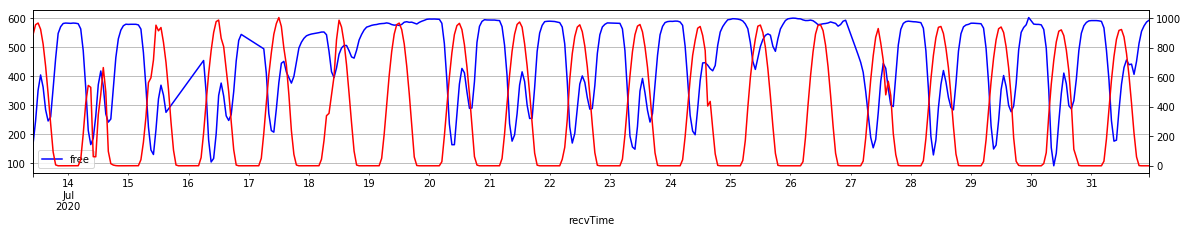

In [222]:
ax= zone1_df.plot(figsize=(20,3),grid=True, color='blue');
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
meteor['radmed'].plot(ax=ax2, color='red');

In [223]:
r, p = pearsonr(zone1_df['free'], meteor['radmed'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.6134855825963059 and p-value: 1.8333086770992193e-47


## Format data

In [224]:
n_steps = 12
T_ = 1

In [225]:
#input: flow(t), flow(t-1), ..,flow(t-prev_hours). output: parking(t+T)
def generate_univariate_time_series_fn(zone_parking, subflow, prev_hours, T=1):
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_value = zone_parking.iloc[prev_hours + i +T -1]
        s = np.append(mob_values,parking_value).reshape(-1,prev_hours+T)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours),. output: parking(t+T)
def generate_univariate_time_series_fn2(zone_parking, subflow, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:(prev_hours + i +T)]
        s = np.append(mob_values,parking_values).reshape(-1,prev_hours*2+T)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours*2+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), weather(t), weather(t-1),...,
#parking(t-prev_hours),. output: parking(t+T)
def generate_univariate_time_series_fn22(zone_parking, subflow, metoro, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        meteoro_values = metoro[i:i+prev_hours].values.reshape(-1,1)
        parking_values = zone_parking.iloc[i + prev_hours +T].values.reshape(-1,1) 
        s = np.concatenate((mob_values,meteoro_values,parking_values), axis=0)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours*5+1,1)
    return series


#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours), meteor(t), meteor(t-1), ..., meteor(t-prev_hours) output: parking(t+T)
def generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours +T].values.reshape(-1,1)
        meteor_values = meteoro[i:i+prev_hours].values.reshape(-1,1)
        s = np.concatenate((mob_values,meteor_values,parking_values), axis=0)
        series.append(s)
    series2 = np.asarray(series, dtype=np.float32)
   
    return series2

In [226]:
def generate_time_series_for_rnn_fn(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        X.append(mob_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,1)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,#parking(t-prev_hours),. 
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn2(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours].values
        two_dim_values = np.concatenate((mob_values, parking_values), axis=0)#.reshape(-1,2)
        X.append(two_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,2)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,parking(t-prev_hours),..,meteo(t),..,meteo(t-prev_hours)
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn3(zone_parking, subflow, meteoro, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours].values
        meteoro_values = meteoro[i:i+prev_hours].values
        
        three_dim_values = np.concatenate((mob_values, parking_values,meteoro_values), axis=1)
        X.append(three_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,6)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y


#input: flow(t), flow(t-1), ..,flow(t-prev_hours),..,meteo(t),..,meteo(t-prev_hours)
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn22(zone_parking, subflow, meteoro, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        meteoro_values = meteoro[i:i+prev_hours].values
        
        two_dim_values = np.concatenate((mob_values, meteoro_values), axis=1)#.reshape(-1,2)
        X.append(two_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,5)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

### Scale data

In [227]:
scaler_flow =  StandardScaler()
flow_scaled = scaler_flow.fit_transform(mob_flows[9].loc[target_days].values)
flow_scaled_df = pd.DataFrame(flow_scaled)
flow_scaled_df.head()

,0
0,1.050581
1,0.537342
2,0.377285
3,0.498533
4,1.536396


In [228]:
scaler_parking =  StandardScaler()
zone_scaled =scaler_parking.fit_transform(zone1_df.values)
parking_scaled_df = pd.DataFrame(zone_scaled)
parking_scaled_df.head()

,0
0,-2.046244
1,-1.477782
2,-0.718037
3,-0.338452
4,-0.639057


In [229]:
scaler_meteor =  StandardScaler()
meteor_scaled =scaler_meteor.fit_transform(meteor.loc[target_days].values)
meteor_scaled_df = pd.DataFrame(meteor_scaled)
meteor_scaled_df.head()

,0,1,2,3
0,0.753114,1.570573,0.615937,-0.060552
1,1.048587,1.754888,1.047641,-0.060552
2,1.133008,1.786113,1.335444,-0.060552
3,1.238534,1.669501,1.623247,-0.060552
4,1.069692,1.395101,2.054951,-0.060552


In [230]:
X,y=generate_time_series_for_rnn_fn3(parking_scaled_df, flow_scaled_df, meteor_scaled_df, 12, 1)

In [231]:
X.shape, y.shape

((433, 12, 6), (433, 12, 1))

### Generate time series samples

In [232]:
ts = generate_univariate_time_series_fn(parking_scaled_df, flow_scaled_df, n_steps, T_)
ts[0]

array([[ 1.05058106],
       [ 0.53734227],
       [ 0.37728519],
       [ 0.49853284],
       [ 1.53639552],
       [ 0.78392941],
       [ 1.05006241],
       [ 0.83789911],
       [ 1.10564543],
       [ 1.02231909],
       [ 0.38188192],
       [-0.26148127],
       [ 0.93845406]])

In [233]:
ts.shape

(433, 13, 1)

In [234]:
ts2= generate_univariate_time_series_fn2(parking_scaled_df, flow_scaled_df, n_steps, T_)
ts2[0]

array([[ 1.05058106],
       [ 0.53734227],
       [ 0.37728519],
       [ 0.49853284],
       [ 1.53639552],
       [ 0.78392941],
       [ 1.05006241],
       [ 0.83789911],
       [ 1.10564543],
       [ 1.02231909],
       [ 0.38188192],
       [-0.26148127],
       [-2.046244  ],
       [-1.47778221],
       [-0.71803673],
       [-0.33845197],
       [-0.63905714],
       [-1.20233915],
       [-1.47972296],
       [-1.37928042],
       [-0.66823939],
       [ 0.07456829],
       [ 0.69192165],
       [ 0.85900859],
       [ 0.93845406]])

In [235]:
ts2.shape

(433, 25, 1)

In [236]:
ts3 = generate_univariate_time_series_fn3(parking_scaled_df, flow_scaled_df, meteor_scaled_df, n_steps, T_)


In [237]:
ts3.shape

(433, 73, 1)

In [238]:
n_series = ts.shape[0]

## Split training-test

In [239]:
training_rate = 0.7

In [240]:
n_series_training = round(n_series * training_rate)


In [241]:
X_train, y_train = ts[:n_series_training,:n_steps], ts[:n_series_training, -1]
X_valid, y_valid = ts[n_series_training:,:n_steps], ts[n_series_training:, -1]

In [242]:
X_train.shape, y_train.shape

((303, 12, 1), (303, 1))

In [243]:
X_valid.shape, y_valid.shape

((130, 12, 1), (130, 1))

In [244]:
def generate_train_test(zone_parking, subflow, meteoro =[], prev_hours = 12, T=1, fun =1, tr= 0.7, nfeatures=1):

    if fun==1:
        ts = generate_univariate_time_series_fn(zone_parking, subflow, n_steps, T_)
    elif fun==2: 
        ts = generate_univariate_time_series_fn2(zone_parking, subflow, n_steps, T_)
    elif fun== 3:
        ts = generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, n_steps, T_)
    else:
        ts = generate_univariate_time_series_fn22(zone_parking, subflow, meteoro, n_steps, T_)
    n_series = ts.shape[0]
    training_rate = tr
    n_series_training = round(n_series * training_rate)
    X_train, y_train = ts[:n_series_training,:n_steps*nfeatures], ts[:n_series_training, -1]
    X_valid, y_valid = ts[n_series_training:,:n_steps*nfeatures], ts[n_series_training:, -1]
    return X_train, y_train, X_valid, y_valid

In [245]:
def generate_train_test_for_rnn(zone_parking, subflow, meteoro =[], prev_hours= 12, T=1, fun =1, tr= 0.7):
    if(fun==1):
        X,Y = generate_time_series_for_rnn_fn(zone_parking, subflow, n_steps, T_)
    elif fun== 2: 
        X,Y = generate_time_series_for_rnn_fn2(zone_parking, subflow, n_steps, T_)
    elif fun ==3:
        X,Y = generate_time_series_for_rnn_fn3(zone_parking, subflow, meteoro, n_steps, T_)
    else:
        X,Y = generate_time_series_for_rnn_fn22(zone_parking, subflow, meteoro, n_steps, T_)
    n_train_samples = round(X.shape[0] * tr)
    X_train = X[:n_train_samples]
    y_train = Y[:n_train_samples]

    X_valid = X[n_train_samples:]
    y_valid = Y[n_train_samples:]
      
    return X_train, y_train, X_valid, y_valid

## Test DNN models

In [246]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    #plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [247]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [248]:
def compute_metrics_fn(y_valid, y_hat, scaler):
    ## actual train and test values
    y_hat_resc = scaler_parking.inverse_transform(y_hat)
    y_valid_resc = scaler_parking.inverse_transform(y_valid)

    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [249]:
def plot_prediction_vs_groundtruth_fn(y_valid, y_hat):
    y_hat_resc = scaler_parking.inverse_transform( y_hat[:,-1].reshape(-1,))
    y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
    plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
    plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
    plt.legend(fontsize=14)
    plt.xlabel("Timestamp")
    plt.ylabel("Free places")
    plt.grid(True)

### MLP - benchmark

In [250]:
import tensorflow as tf
from tensorflow import keras

In [251]:
np.random.seed(42)
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])

model_mlp.compile(loss="mse", optimizer="adam")
history = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
10/10 [==============================] - 1s 46ms/step - loss: 1.2650 - val_loss: 1.3119
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 1.1173 - val_loss: 1.2419
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 1.1585 - val_loss: 1.1821
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 1.0580 - val_loss: 1.1292
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.9420 - val_loss: 1.0843
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.9040 - val_loss: 1.0472
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 1.0046 - val_loss: 1.0128
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.9499 - val_loss: 0.9852
Epoch 9/100
10/10 [==============================] - 0s 5ms/step - loss: 0.8719 - val_loss: 0.9637
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8216 - val_loss: 0.9459
Epoch 11

Epoch 83/100
10/10 [==============================] - 0s 8ms/step - loss: 0.5072 - val_loss: 0.6490
Epoch 84/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5279 - val_loss: 0.6482
Epoch 85/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5459 - val_loss: 0.6479
Epoch 86/100
10/10 [==============================] - 0s 6ms/step - loss: 0.4841 - val_loss: 0.6467
Epoch 87/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4934 - val_loss: 0.6451
Epoch 88/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5774 - val_loss: 0.6437
Epoch 89/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4959 - val_loss: 0.6420
Epoch 90/100
10/10 [==============================] - 0s 6ms/step - loss: 0.5144 - val_loss: 0.6413
Epoch 91/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4374 - val_loss: 0.6408
Epoch 92/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4555 - val_loss: 0.6395


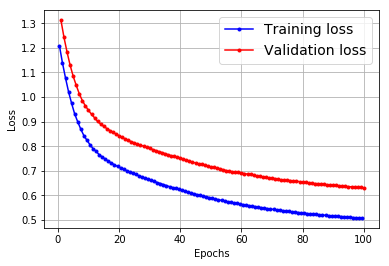

In [252]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [253]:
y_hat = model_mlp.predict(X_valid)

#### Get metrics

In [254]:
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))

MAE: 85.402, MSE: 12116.277, RMSE: 110.074, CVRMSE: 24.928, MAPE: 24.703


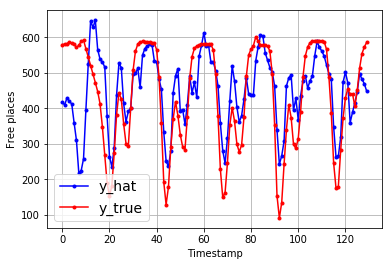

In [255]:
plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

In [256]:
def mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    model_mlp = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[n_steps*nfeatures, 1]),
        keras.layers.Dense(50),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(50),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(50),

        keras.layers.Dense(1)
    ])

    model_mlp.compile(loss="mse", optimizer="adam")
    history = model_mlp.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_valid, y_valid))
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    y_hat = model_mlp.predict(X_valid)#.reshape(-1,)
    #print(y_hat.shape, y_valid.shape)
    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)
    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

 Model with flows as inputs

(303, 12, 1) (303, 1) (130, 12, 1) (130, 1)


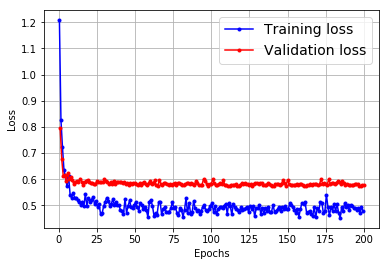

MAE: 81.804, MSE: 11082.394, RMSE: 105.273, CVRMSE: 23.841, MAPE: 24.622


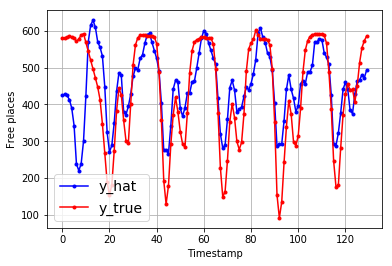

In [257]:
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, 
                                                         flow_scaled_df, 
                                                         prev_hours=n_steps, 
                                                         fun= 1,
                                                         T=1)
mlp_benchmark(X_train, y_train, X_valid, y_valid)

(303, 24, 1) (303, 1) (130, 24, 1) (130, 1)


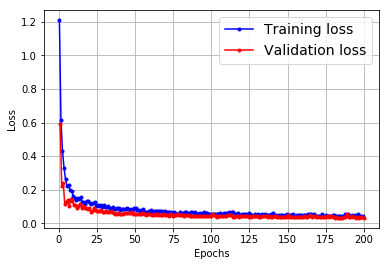

MAE: 19.422, MSE: 639.337, RMSE: 25.285, CVRMSE: 5.726, MAPE: 5.501


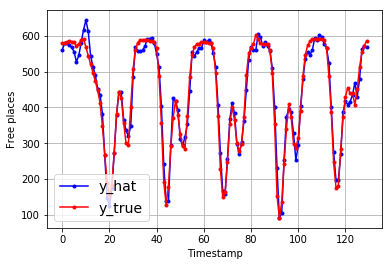

In [258]:
# Model with flows and parking as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, flow_scaled_df, 
                                                         prev_hours=n_steps, T=1, fun = 2, nfeatures=2)
mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=2)

Model with flows, parkings and meteorological data as inputs

(303, 72, 1) (303, 1) (130, 72, 1) (130, 1)


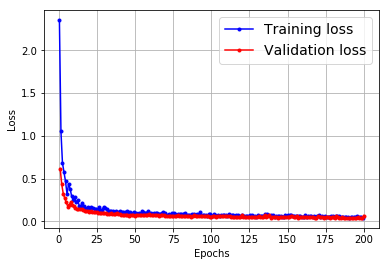

MAE: 30.139, MSE: 1334.734, RMSE: 36.534, CVRMSE: 8.274, MAPE: 9.272


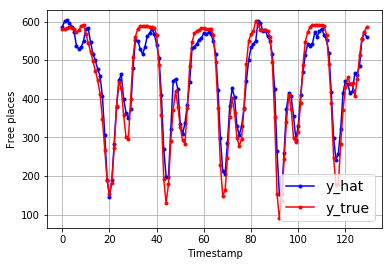

In [259]:
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, 
                                                         flow_scaled_df, 
                                                         meteor_scaled_df,
                                                         prev_hours=n_steps, T=1, fun = 3, nfeatures=6)

mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=6) 

Model with flows and weather as inputs

(303, 60, 1) (303, 1) (130, 60, 1) (130, 1)


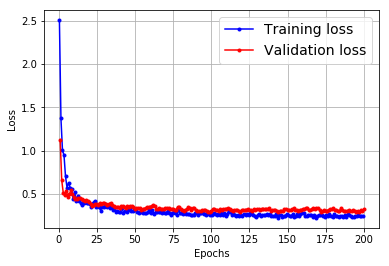

MAE: 61.363, MSE: 6207.406, RMSE: 78.787, CVRMSE: 17.839, MAPE: 21.044


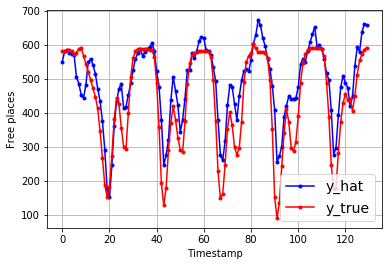

In [260]:
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, 
                                                         flow_scaled_df, 
                                                         meteor_scaled_df,
                                                         prev_hours=n_steps, 
                                                         T=1, 
                                                         nfeatures=5,
                                                         fun = 4)
mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=5)

###  GRU model

In [261]:
def gru_model(X_train, y_train, X_valid, y_valid, fun=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    model_gru = keras.models.Sequential([
        keras.layers.GRU(50, return_sequences=True,  input_shape=[None, fun]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(20)),
        keras.layers.Dense(1)
    ])

    model_gru.compile(loss="mse", optimizer="adam")
    history = model_gru.fit(X_train, y_train, verbose=0, epochs=100, validation_data=(X_valid, y_valid))
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    y_hat = model_gru.predict(X_valid)

    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), y_hat[:,-1].reshape(-1,), scaler_parking)

    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

Only with flow as input

In [262]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=1)

In [263]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((303, 12, 1), (303, 12, 1), (130, 12, 1), (130, 12, 1))

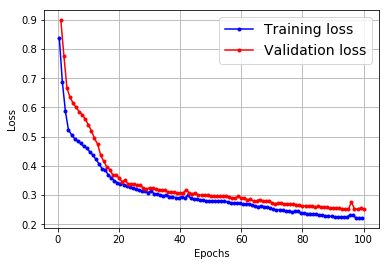

MAE: 35.882, MSE: 2531.966, RMSE: 50.319, CVRMSE: 11.395, MAPE: 10.432


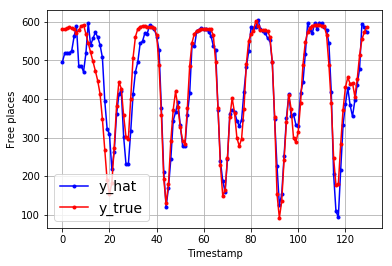

In [264]:
gru_model(X_train, y_train, X_valid, y_valid)

Now we try with flow + parking as input

In [265]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=2)

In [266]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((303, 12, 2), (303, 12, 1), (130, 12, 2), (130, 12, 1))

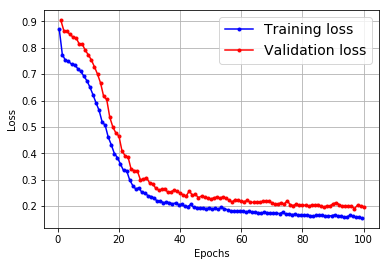

MAE: 30.257, MSE: 1504.014, RMSE: 38.782, CVRMSE: 8.783, MAPE: 9.014


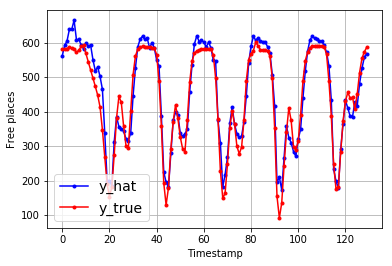

In [267]:
gru_model(X_train, y_train, X_valid, y_valid, 2)

Flow + weather

In [268]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                meteor_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=4)

In [269]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((303, 12, 5), (303, 12, 1), (130, 12, 5), (130, 12, 1))

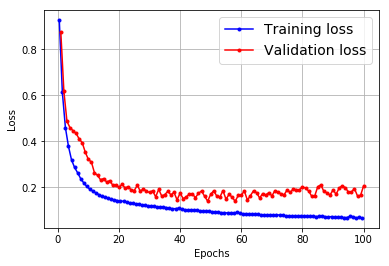

MAE: 62.444, MSE: 5579.843, RMSE: 74.698, CVRMSE: 16.916, MAPE: 17.566


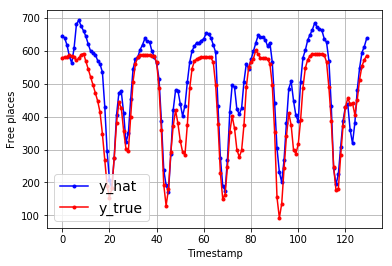

In [270]:
gru_model(X_train, y_train, X_valid, y_valid, 5)

------------------------------------

Now with flow+parking+weather

In [271]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                meteor_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=3)

In [272]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((303, 12, 6), (303, 12, 1), (130, 12, 6), (130, 12, 1))

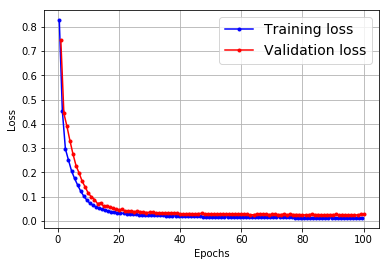

MAE: 15.360, MSE: 398.455, RMSE: 19.961, CVRMSE: 4.521, MAPE: 4.827


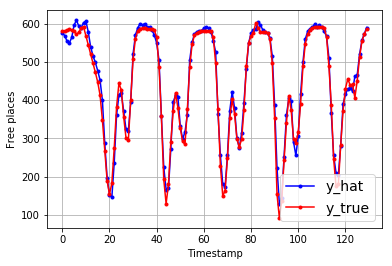

In [273]:
gru_model(X_train, y_train, X_valid, y_valid, 6)

### Naive approach

We just predict with the last value of the parking

In [274]:
y_hat= X_valid[:,11,-5]

MAE: 43.941, MSE: 3744.474, RMSE: 61.192, CVRMSE: 13.858, MAPE: 14.380


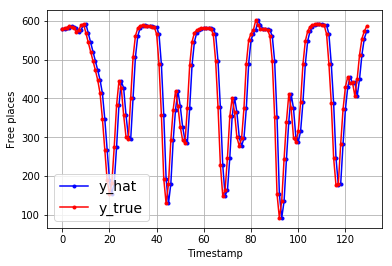

In [275]:
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), 
                                                       y_hat, 
                                                       scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))

y_hat_resc = scaler_parking.inverse_transform( y_hat)
y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
plt.legend(fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Free places")
plt.grid(True)

In [276]:
print("That's all folks!")

That's all folks!
